# Time Series Forecasting Project


### Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
import statsmodels.api as sm
from statsmodels.tsa.api import Holt

In [2]:
def nulls_by_col(df):
    '''
    Determines the number of nulls for each column
    '''
    num_missing = df.isnull().sum()
    rows = df.shape[0]
    prcnt_miss = num_missing / rows * 100
    cols_missing = pd.DataFrame({'num_rows_missing': num_missing, 'percent_rows_missing': prcnt_miss})
    return cols_missing

def nulls_by_row(df):
    '''
    Determines the number of nulls for each row
    '''
    num_missing = df.isnull().sum(axis=1)
    prcnt_miss = num_missing / df.shape[1] * 100
    rows_missing = pd.DataFrame({'num_cols_missing': num_missing, 'percent_cols_missing': prcnt_miss})\
    .reset_index()\
    .groupby(['num_cols_missing', 'percent_cols_missing']).count()\
    .rename(index=str, columns={'customer_id': 'num_rows'}).reset_index()
    return rows_missing

def col_desc(df):
    '''
    Preforms a .describe on a dataframe as well as adding the range of each col
    '''
    stats_df = df.describe().T
    stats_df['range'] = stats_df['max'] - stats_df['min']
    return stats_df

def summarize(df):
    '''
    Function to summarize a dataframe, will take in a single argument (a pandas dataframe)
    and output to console various statistics on said dataframe, including:
    - .info()
    - .describe()
    - .value_counts()
    - Observation of nulls in the dataframe
    - Column stats
    '''
    print('=====================================================\n\n')
    print('Dataframe info: ')
    print(df.info())
    print('=====================================================\n\n')
    print('Dataframe Description: ')
    print(df.describe())
    print('=====================================================\n\n')
    print('Dataframe Value Counts: ')
    for col in df.columns:
        print(df[col].value_counts())
    print('=====================================================\n\n')
    print('Nulls by Column: ')
    print(nulls_by_col(df))
    print('=====================================================\n\n')
    print('Nulls by Row: ')
    print(nulls_by_row(df))
    print('=====================================================\n\n')
    print('Column Stats: ')
    print(col_desc(df))
    print('============================================')

def C_to_F(C):
    '''
    takes in a list of ints or floats and converts it to farenheigt
    '''
    F = 9.0/5.0 * C + 32
    return F


In [3]:
# plotting defaults
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

# Acquire

In [4]:
# Pulling csv from local storage
df = pd.read_csv('GlobalLandTemperaturesByCity.csv')

In [5]:
df.head(3)

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


In [6]:
# Choosing country (Japan)
df = df[df.Country == 'Japan']
df.shape

(358669, 7)

In [7]:
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
45530,1845-01-01,2.377,2.006,Abiko,Japan,36.17N,139.23E
45531,1845-02-01,1.312,2.968,Abiko,Japan,36.17N,139.23E
45532,1845-03-01,5.276,1.506,Abiko,Japan,36.17N,139.23E
45533,1845-04-01,10.387,1.508,Abiko,Japan,36.17N,139.23E
45534,1845-05-01,14.923,1.448,Abiko,Japan,36.17N,139.23E


In [8]:
# Checking for number of missing vals in each col
for col in df.columns:
    print(f'{col}: {df[col].isna().sum()}')

dt: 0
AverageTemperature: 2202
AverageTemperatureUncertainty: 2202
City: 0
Country: 0
Latitude: 0
Longitude: 0


In [9]:
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
45530,1845-01-01,2.377,2.006,Abiko,Japan,36.17N,139.23E
45531,1845-02-01,1.312,2.968,Abiko,Japan,36.17N,139.23E
45532,1845-03-01,5.276,1.506,Abiko,Japan,36.17N,139.23E
45533,1845-04-01,10.387,1.508,Abiko,Japan,36.17N,139.23E
45534,1845-05-01,14.923,1.448,Abiko,Japan,36.17N,139.23E


# Prepare
- Check distributions
- Convert to datetime index
- Create columns from datetime index
- Deal with missing vals
- Split data

In [10]:
# Converting Date type object to datetime64
df.dt = pd.to_datetime(df.dt, format = '%Y-%m-%d')
    
# Making the index equal to the Date column
df = df.set_index('dt').sort_index()

# Creating a column named month
df['month'] = pd.DatetimeIndex(df.index).month
    
# Creating a column named year
df['year'] = pd.DatetimeIndex(df.index).year

In [11]:
df.head()

,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,month,year
dt,,,,,,,,
1839-01-01,-8.984,2.264,Kitami,Japan,44.20N,143.11E,1,1839
1839-01-01,-8.984,2.264,Asahikawa,Japan,44.20N,143.11E,1,1839
1839-02-01,-8.502,2.366,Asahikawa,Japan,44.20N,143.11E,2,1839
1839-02-01,-8.502,2.366,Kitami,Japan,44.20N,143.11E,2,1839
1839-03-01,-6.355,1.962,Kitami,Japan,44.20N,143.11E,3,1839


In [12]:
# Finding nulls
nulls_temp = df[df.AverageTemperature.isnull()]
nulls_unc = df[df.AverageTemperatureUncertainty.isnull()]

(nulls_temp.index == nulls_unc.index).sum(), nulls_temp.shape, nulls_unc.shape

(2202, (2202, 8), (2202, 8))

Rows where average temp are missing are the same rows where temp uncertainty are missing, will likely drop them

In [13]:
# Dropping nulls
df = df.dropna()

In [14]:
# Checking for any leftovers
df.isnull().sum()

AverageTemperature               0
AverageTemperatureUncertainty    0
City                             0
Country                          0
Latitude                         0
Longitude                        0
month                            0
year                             0
dtype: int64

In [15]:
# Changing from C to F
df['AverageTemperature'] = C_to_F(df.AverageTemperature)

In [16]:
# Target var df
daily_temp = df[['AverageTemperature', 'month', 'year']].dropna().drop_duplicates().resample('M').mean().rename(columns = {'AverageTemperature':'avg_temp'})

In [17]:
daily_temp.head(3)

,avg_temp,month,year
dt,,,
1839-01-31,15.8288,1.0,1839.0
1839-02-28,16.6964,2.0,1839.0
1839-03-31,20.5610,3.0,1839.0


Difference in temps early could throw off models, will drop before 1843

#### Split

In [18]:
# Splitting
train = daily_temp[:'1930'].drop(columns = ['month', 'year'])
validate = daily_temp['1931':'1975'].drop(columns = ['month', 'year'])
test = daily_temp['1976':].drop(columns = ['month', 'year'])

In [19]:
train.shape, validate.shape, test.shape

((1104, 1), (540, 1), (452, 1))

In [20]:
# test the split between validate and test
pd.concat([train.tail(1), validate.head(1)])

,avg_temp
dt,
1930-12-31,39.586229
1931-01-31,34.399486


In [21]:
# quality check
len(train) + len(validate) + len(test) == len(daily_temp)

True

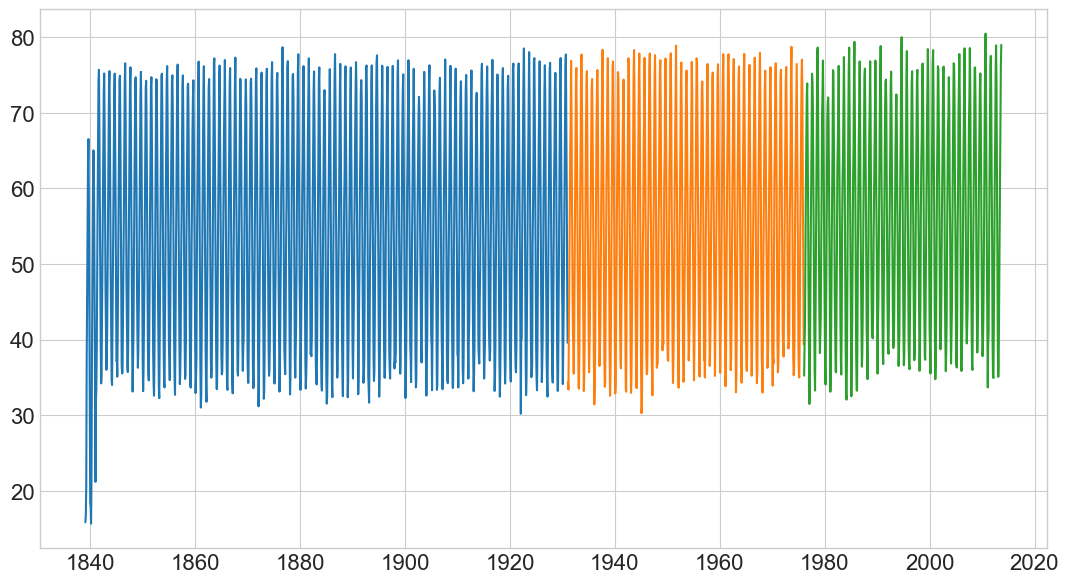

In [22]:
# Visualizing split
plt.plot(train.index, train.avg_temp)
plt.plot(validate.index, validate.avg_temp)
plt.plot(test.index, test.avg_temp)

plt.show()

# Explore

In [23]:
# Setting y to target
y = train.avg_temp

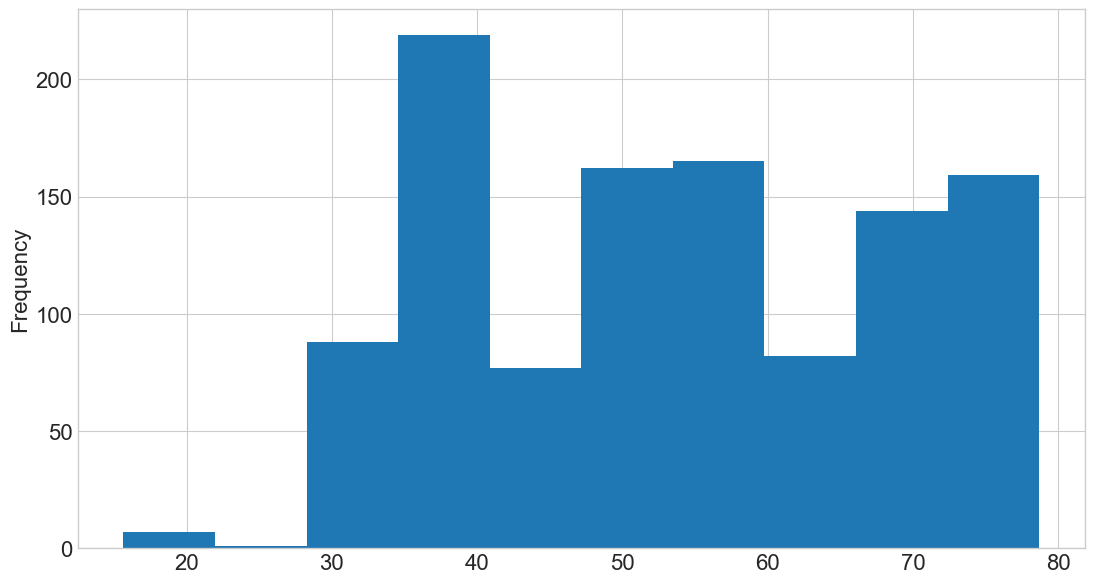

In [24]:
# Distributions
y.plot.hist()
plt.show()

### Target Var. Dist.:
- Non-normal distributions
- Most frequent temp clusters:
    - 35-40 degrees
    - 50-60 degrees
    - 65-75 degrees

## Visualizationing Avg. Temperature Over time

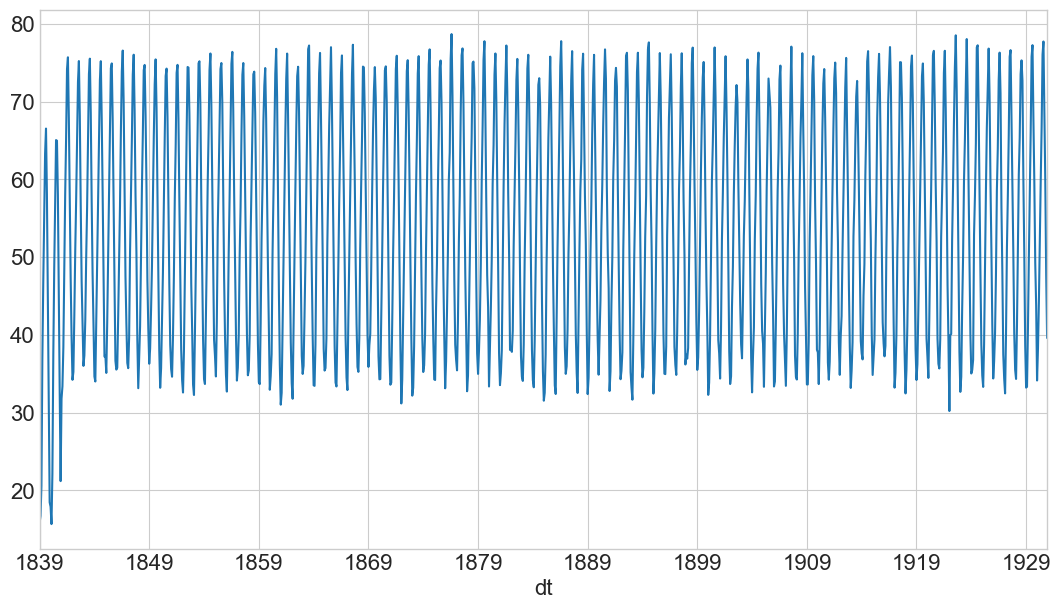

In [25]:
# Target var over time
y.plot()
plt.show()

#### Monthly Visualizations

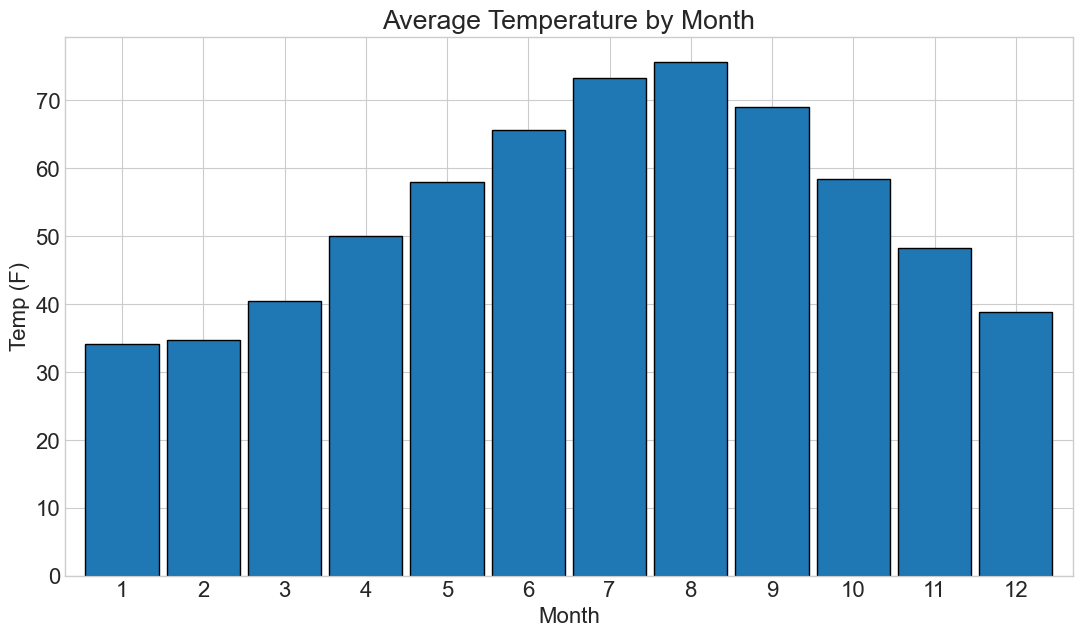

In [26]:
ax = y.groupby(y.index.month).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Average Temperature by Month', xlabel='Month', ylabel='Temp (F)')
plt.show()

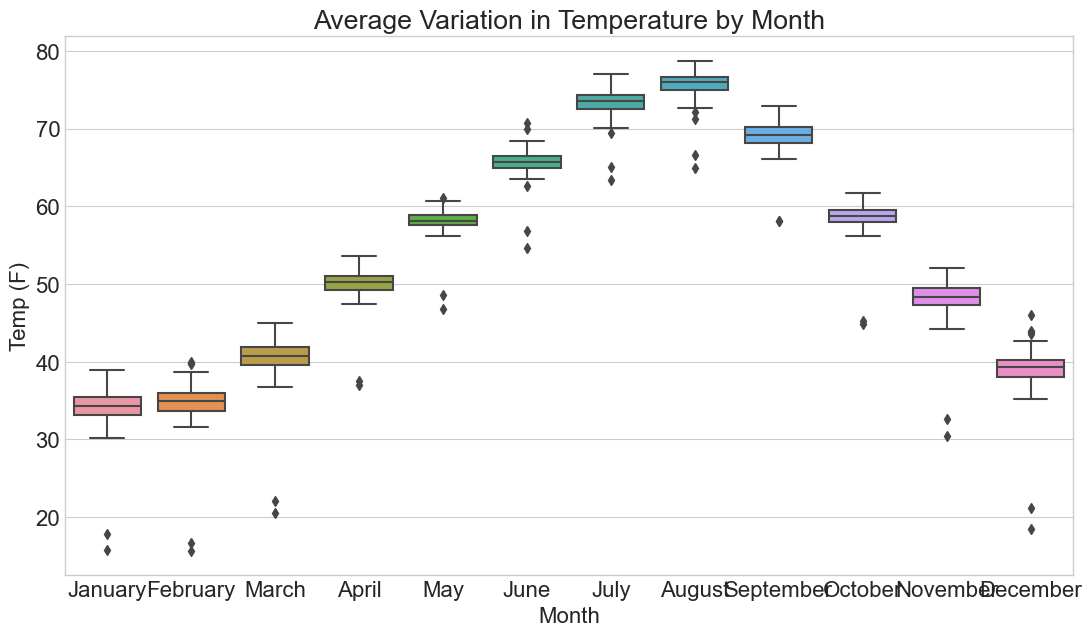

In [27]:
ax = (
     y.reset_index()
    .assign(month=lambda df: y.index.month_name())
    .pipe((sns.boxplot, 'data'), y='avg_temp', x='month')
)
ax.set(title='Average Variation in Temperature by Month', xlabel='Month', ylabel='Temp (F)')
plt.show()

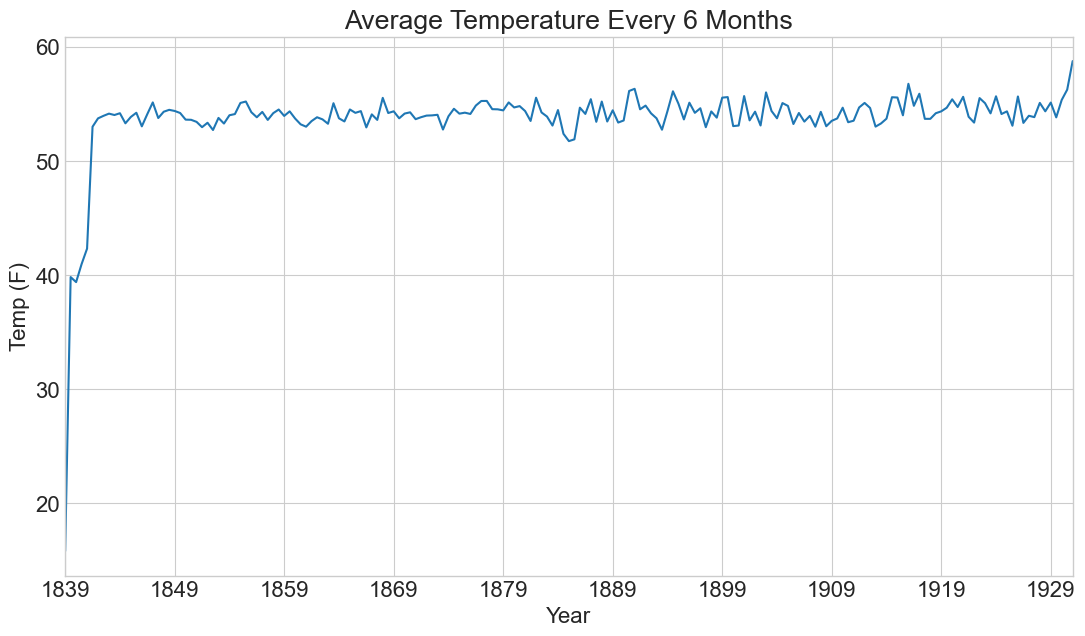

In [28]:
ax = y.resample('6M').mean().plot(title='6 Month Average')
plt.xticks(rotation=0)
ax.set(title='Average Temperature Every 6 Months', xlabel='Year', ylabel='Temp (F)')
plt.show()

#### Decade Visualizations

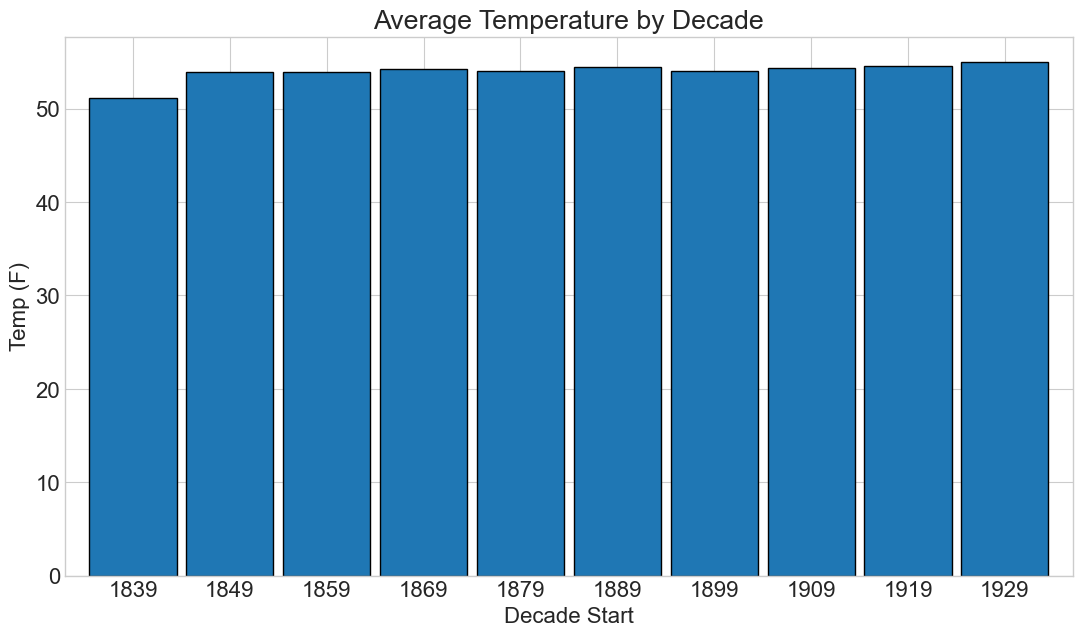

In [29]:
ax = y.resample('10Y', kind = 'period').mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Average Temperature by Decade', xlabel='Decade Start', ylabel='Temp (F)')
plt.show()

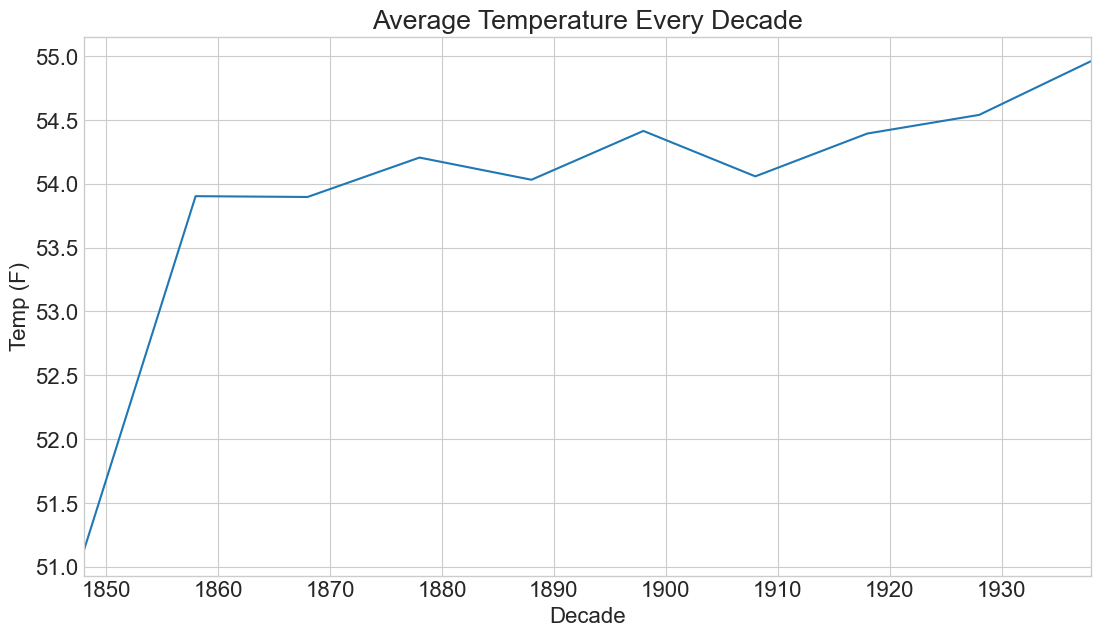

In [30]:
ax = y.resample('10Y', kind = 'period').mean().plot(title='6 Month Average')
plt.xticks(rotation=0)
ax.set(title='Average Temperature Every Decade', xlabel='Decade', ylabel='Temp (F)')
plt.show()

### Seasonality Plots

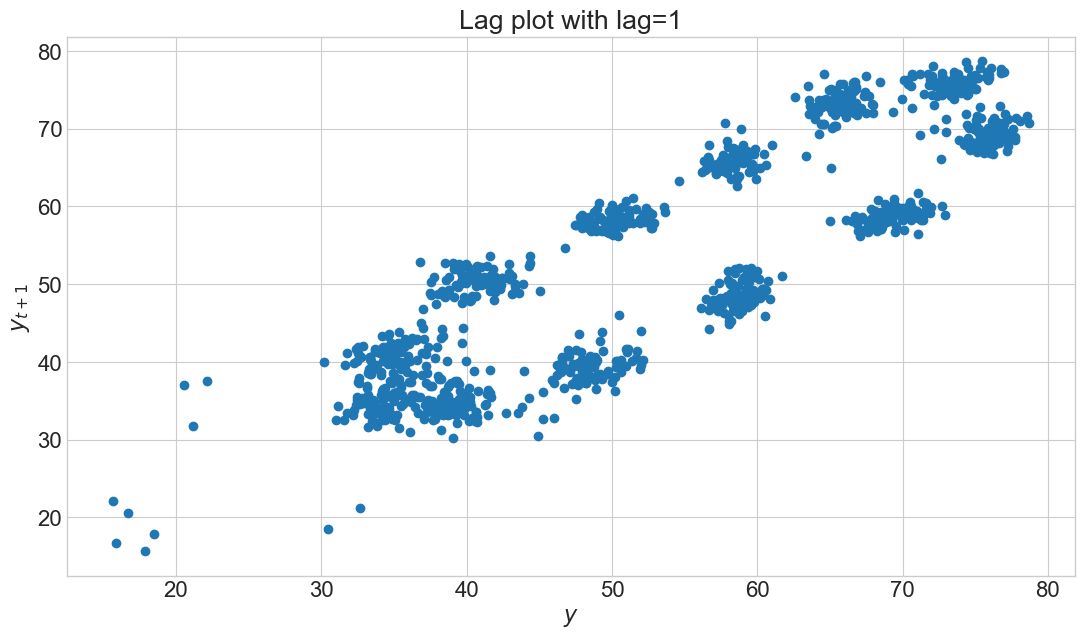

In [31]:
plt.scatter(y, y.shift(-1))
plt.xlabel('$y$')
plt.ylabel('$y_{t + 1}$')
plt.title('Lag plot with lag=1')
plt.show()

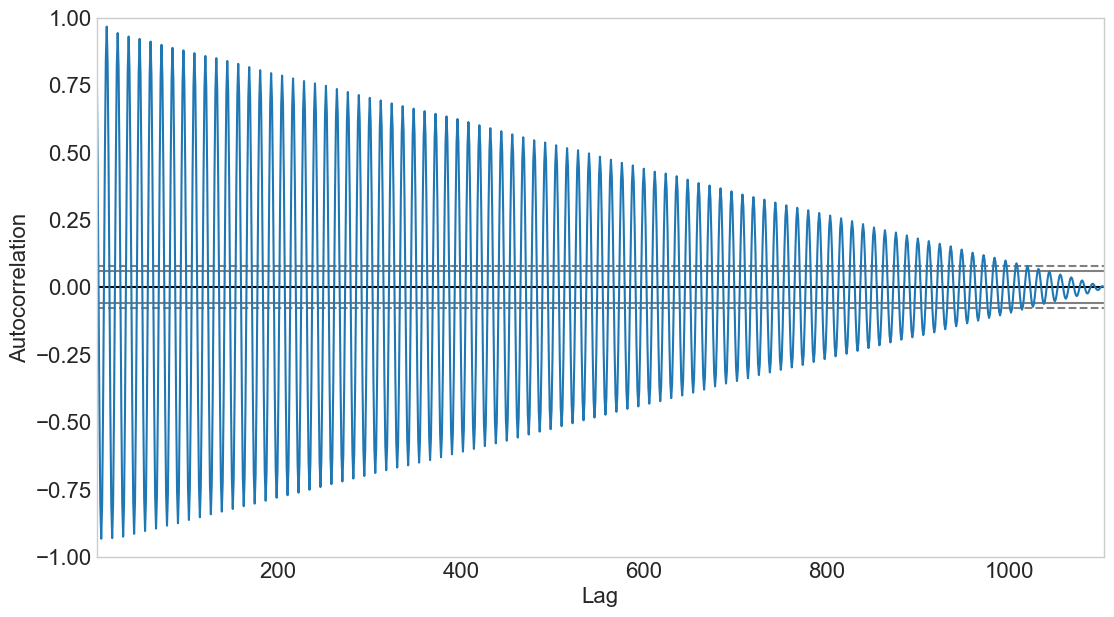

In [32]:
pd.plotting.autocorrelation_plot(y)
plt.show()

In [33]:
result = sm.tsa.seasonal_decompose(y)
decomposition = pd.DataFrame({
    'y': result.observed,
    'trend': result.trend,
    'seasonal': result.seasonal,
    'resid': result.resid,
})
decomposition.head()

,y,trend,seasonal,resid
dt,,,,
1839-01-31,15.8288,NaN,-19.588706,NaN
1839-02-28,16.6964,NaN,-19.086137,NaN
1839-03-31,20.5610,NaN,-13.351133,NaN
1839-04-30,36.9842,NaN,-3.804647,NaN
1839-05-31,46.7780,NaN,4.163171,NaN


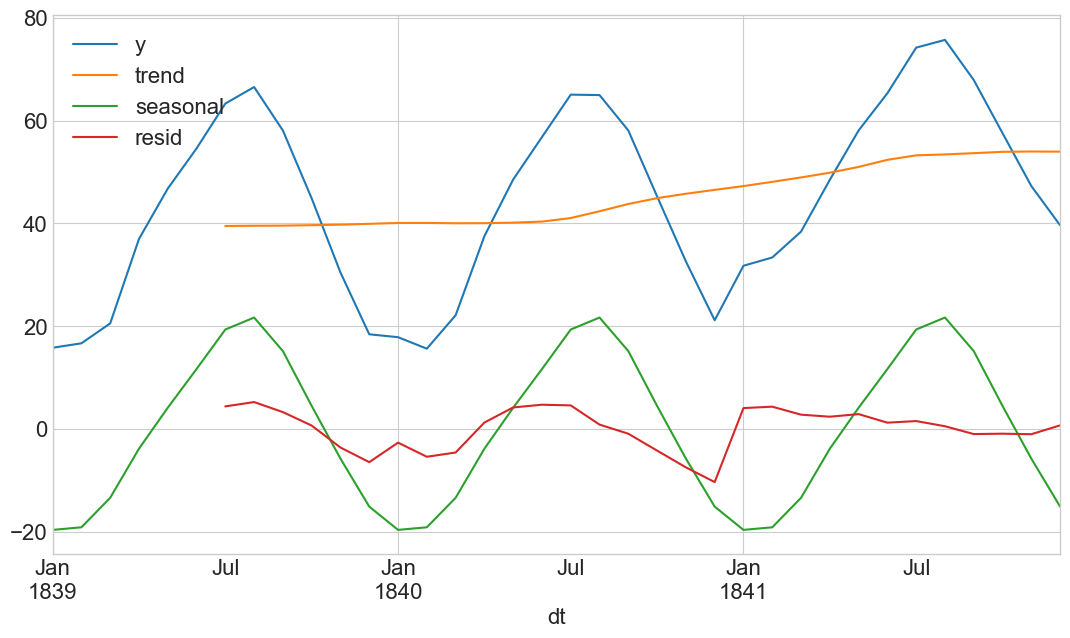

In [34]:
decomposition.iloc[0:36].plot()
plt.show()

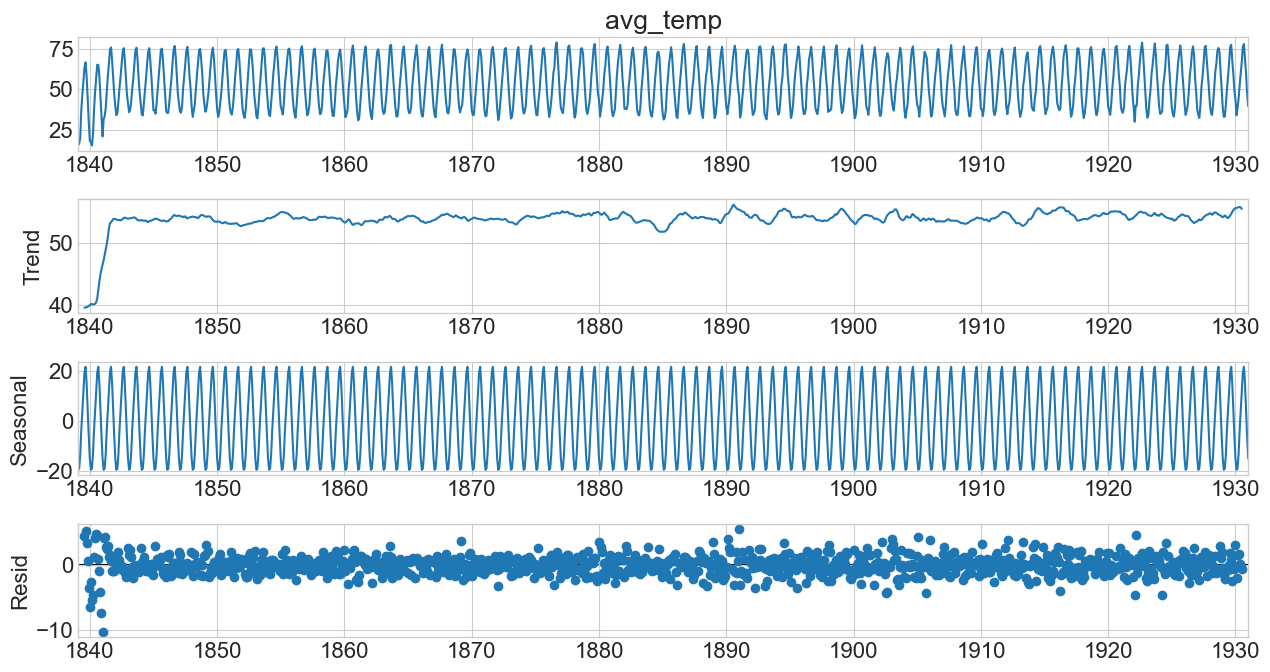

In [35]:
result.plot()
plt.show()
None

# Modeling

### Model Funcs and Preliminary Prep

In [36]:
def plot_samples(target_var):
    '''
    this function will plot the train, validate and test values for a single variable across all dates. 
    '''
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var])
    plt.plot(validate[target_var])
    plt.plot(test[target_var])
    plt.title(target_var)

In [37]:
def evaluate(target_var):
    '''
    the evaluate function will take in the actual values in validate and the predicted values
    and compute the mean_squared_error and then take the square root and round to 0 decimals. 
    It will return the rmse, an integer. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 3)
    return rmse

In [38]:
# plot and evaluate: plot
def plot_and_eval(target_var):
    '''
    a function to evaluate forecasts by computing the rmse and plot train and validate along with predictions
    '''
    plot_samples(target_var)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    plt.show()
    rmse = evaluate(target_var)
    print(target_var, '--RMSE: {:.3f}'.format(rmse))


In [39]:
# Define function to store rmse for comparison purposes

def append_eval_df(model_type, target_var):
    '''
    this function is going to take in the model_type as a string, the target variable as a string, 
    and run the evaluate() function to compute the rmse, 
    and append the data frame a row with tghe model_type, target_var, and rmse. 
    It will return the new dataframe. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': 'avg_temp', 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index=True)
    

In [40]:
def make_predictions(target_var):
    yhat_df = pd.DataFrame({'avg_temp': [target_var]}, index = validate.index)
    return yhat_df

In [41]:
# Create the empty dataframe with model_type, target_var, rmse
eval_df = pd.DataFrame(columns = ['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


### Forecast: Last Observed

In [42]:
temp = train['avg_temp'][-1]
temp

39.58622857142857

In [43]:
yhat_df = make_predictions(temp)
yhat_df

,avg_temp
dt,
1931-01-31,39.586229
1931-02-28,39.586229
1931-03-31,39.586229
1931-04-30,39.586229
1931-05-31,39.586229
...,...
1975-08-31,39.586229
1975-09-30,39.586229
1975-10-31,39.586229


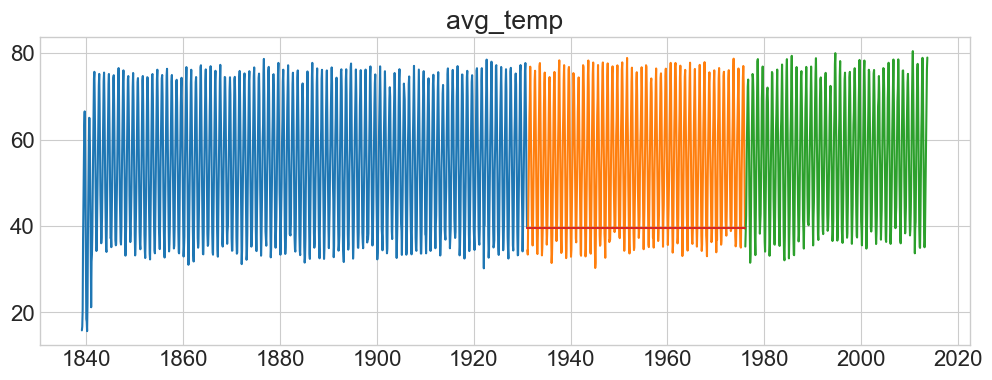

avg_temp --RMSE: 21.077


In [44]:
plot_and_eval('avg_temp')

In [45]:
eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = 'avg_temp')
eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,21.077


### Forecast: Simple Average

In [46]:
# simple average
validate['simp_avg'] = train.avg_temp.mean()

In [47]:
temp = train.avg_temp.mean()

yhat_df = make_predictions(temp)
yhat_df

,avg_temp
dt,
1931-01-31,53.864124
1931-02-28,53.864124
1931-03-31,53.864124
1931-04-30,53.864124
1931-05-31,53.864124
...,...
1975-08-31,53.864124
1975-09-30,53.864124
1975-10-31,53.864124


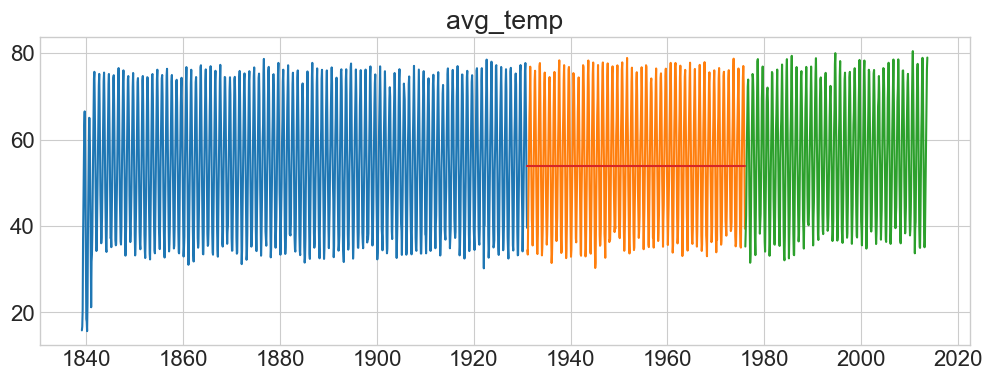

avg_temp --RMSE: 14.341


In [48]:
plot_and_eval('avg_temp')

In [49]:
eval_df = append_eval_df(model_type = 'simple_avg', 
                             target_var = 'avg_temp')
eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,21.077
1,simple_avg,avg_temp,14.341


### Forecast: Rolling 3 Month Average

In [50]:
# rolling average
validate['rolling_3_month'] = train.avg_temp.rolling(3).mean()[-1]

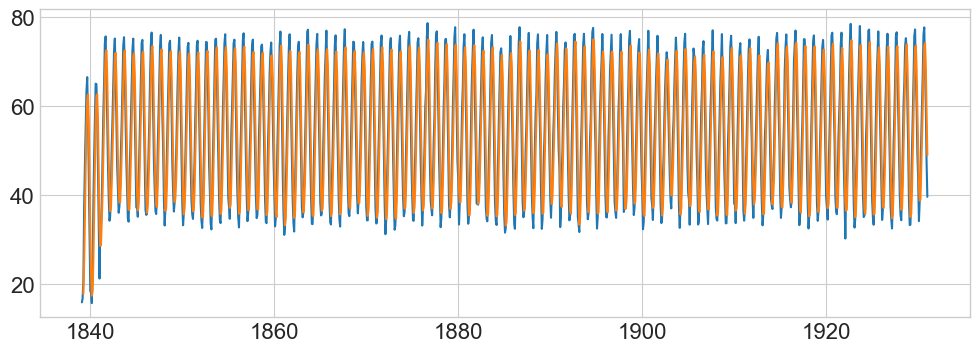

In [51]:
plt.figure(figsize=(12,4))
plt.plot(train['avg_temp'])
plt.plot(train['avg_temp'].rolling(3).mean())
plt.show()

In [52]:
temp = train.avg_temp.rolling(3).mean()[-1]

yhat_df = make_predictions(temp)
yhat_df.head(1)

,avg_temp
dt,
1931-01-31,49.000943


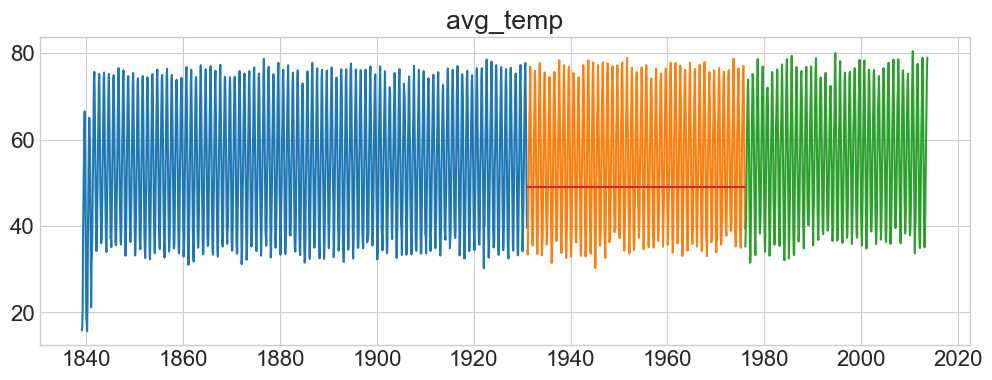

avg_temp --RMSE: 15.529


In [53]:
plot_and_eval('avg_temp')

In [54]:
eval_df = append_eval_df(model_type = 'rolling_3', 
                             target_var = 'avg_temp')
eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,21.077
1,simple_avg,avg_temp,14.341
2,rolling_3,avg_temp,15.529


### Forecast: Holt's

In [55]:
# Holts
model = Holt(train['avg_temp'], exponential = False) # make thing

model = model.fit(smoothing_level = .2, smoothing_slope = .1, optimized = False) # fit thing

validate['Holt1'] = model.predict(start = validate.index[0], 
                                       end = validate.index[-1]) # thing predicts

In [56]:
temp = model.predict(start = validate.index[0], 
                    end = validate.index[-1])

yhat_df['avg_temp'] = temp
yhat_df.head(10)

,avg_temp
dt,
1931-01-31,57.459404
1931-02-28,57.498229
1931-03-31,57.537054
1931-04-30,57.575879
1931-05-31,57.614704
1931-06-30,57.653529
1931-07-31,57.692354
1931-08-31,57.731179
1931-09-30,57.770004


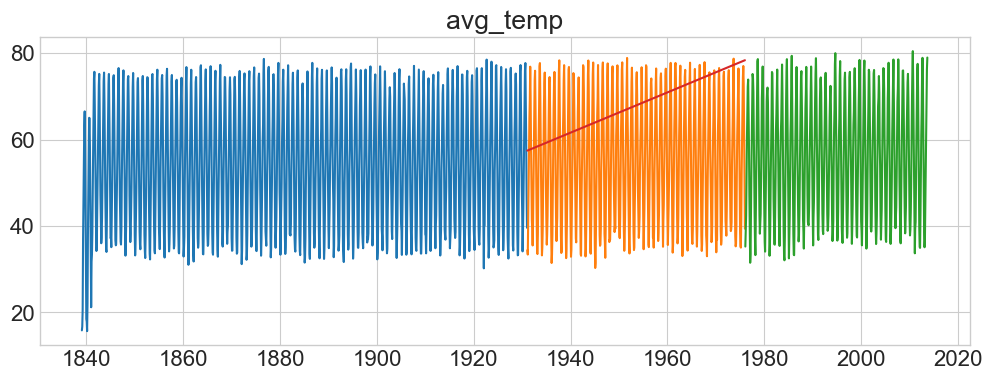

avg_temp --RMSE: 20.026


In [57]:
plot_and_eval('avg_temp')

In [58]:
eval_df = append_eval_df(model_type = 'Holts', 
                             target_var = 'avg_temp')
eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,21.077
1,simple_avg,avg_temp,14.341
2,rolling_3,avg_temp,15.529
3,Holts,avg_temp,20.026


### Forecast: 3 Month Difference

In [59]:
# 3 month diff
diff_3_month = train.avg_temp.diff(3).mean()
validate['diff_3_month'] = list(train[1098 - 534:].avg_temp)
validate['diff_3_month'] = validate['diff_3_month'] + diff_3_month

In [60]:
temp = validate.diff_3_month

yhat_df['avg_temp'] = temp
yhat_df

,avg_temp
dt,
1931-01-31,33.596958
1931-02-28,32.469301
1931-03-31,41.723787
1931-04-30,51.278444
1931-05-31,58.680730
...,...
1975-08-31,77.819873
1975-09-30,69.009130
1975-10-31,59.846615


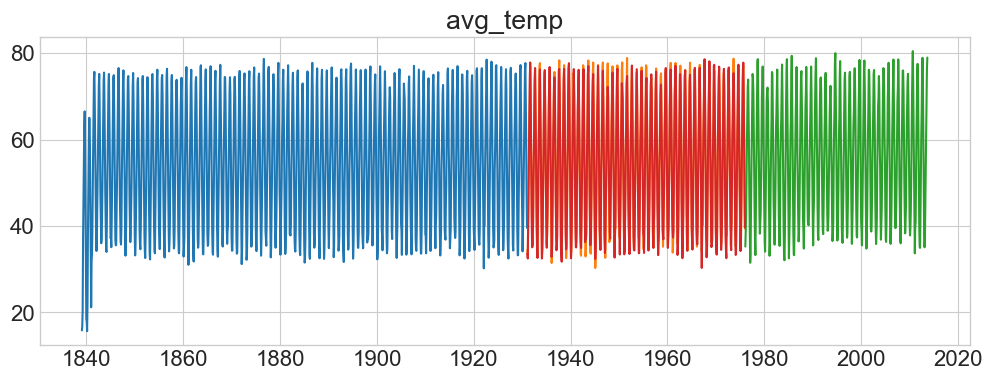

avg_temp --RMSE: 2.408


In [61]:
plot_and_eval('avg_temp')

In [62]:
eval_df = append_eval_df(model_type = 'three_mo_diff', 
                             target_var = 'avg_temp')
eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,21.077
1,simple_avg,avg_temp,14.341
2,rolling_3,avg_temp,15.529
3,Holts,avg_temp,20.026
4,three_mo_diff,avg_temp,2.408


### Forecast: Previous Cycle

In [63]:
def append_eval_df(model_type, target_var):
    '''
    this function is going to take in the model_type as a string, the target variable as a string, 
    and run the evaluate() function to compute the rmse, 
    and append the data frame a row with tghe model_type, target_var, and rmse. 
    It will return the new dataframe. 
    '''
    rmse = round(sqrt(mean_squared_error(val['avg_temp'], yhat_df['avg_temp'])), 3)
    d = {'model_type': [model_type], 'target_var': 'avg_temp', 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index=True)

In [64]:
def plot_and_eval(target_var):
    '''
    a function to evaluate forecasts by computing the rmse and plot train and validate along with predictions
    '''
    plot_samples(target_var)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    plt.show()
    rmse = round(sqrt(mean_squared_error(val['avg_temp'], yhat_df['avg_temp'])), 3)
    print(target_var, '--RMSE: {:.3f}'.format(rmse))

In [65]:
# Copying datarames for secondary splitting
tr = train.copy()
val = validate.copy()
ts = test.copy()

tr = daily_temp[['avg_temp']][:'2011']
val = daily_temp[['avg_temp']]['2012']
ts = daily_temp[['avg_temp']]['2012':'2013']

In [66]:
temp = tr[tr.index.year == 2011] + tr.diff(12).mean()

In [67]:
yhat_df = temp

In [68]:
# set yhat_df to index of validate
yhat_df = yhat_df.set_index(val.index)

In [69]:
yhat_df

,avg_temp
dt,
2012-01-31,33.770206
2012-02-29,39.506935
2012-03-31,41.019921
2012-04-30,51.461892
2012-05-31,60.194121
2012-06-30,68.735721
2012-07-31,75.975921
2012-08-31,77.640492
2012-09-30,72.147663


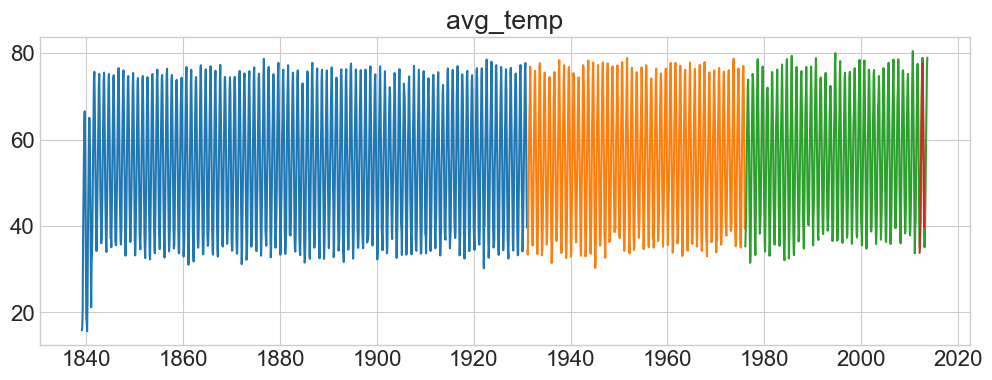

avg_temp --RMSE: 2.118


In [70]:
plot_and_eval('avg_temp')

In [71]:
eval_df = append_eval_df(model_type = 'cycle_one_year', 
                             target_var = 'avg_temp')
eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,21.077
1,simple_avg,avg_temp,14.341
2,rolling_3,avg_temp,15.529
3,Holts,avg_temp,20.026
4,three_mo_diff,avg_temp,2.408
5,cycle_one_year,avg_temp,2.118


# Conclusion:
> - Best preforming model:
    - Cycle based on year
    - Beat other models significantly except the close runner up of 3 month difference